In [1]:
import copy
import logging
import json
import random

from collections import OrderedDict
def jsonDefault(OrderedDict):
    return OrderedDict.__dict__

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

In [2]:
# create logger
logger = logging.getLogger('application_logger')
level = logging.NOTSET
#level = logging.DEBUG
logger.setLevel(level)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(level)

# create formatter
formatter = logging.Formatter('%(levelname)s %(funcName)s %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [3]:
def roll_dice(number, die_type, modifier= 0):
    roll = 0
    for _ in range(number):
        roll = roll + random.randint(1, die_type)
    roll = roll + modifier
    logger.debug(f"{number}d{die_type}+{modifier} = {roll}")
    return roll

In [72]:
Modifier = {
    1: -5,
    2: -4,
    3: -4,
    4: -3,
    5: -3,    
    6: -2,
    7: -2,
    8: -1,
    9: -1,
    10: 0,
    11: 0,
    12: 1,
    13: 1,
    14: 2,
    15: 2,
    16: 3,
    17: 3,
    18: 4,
    19: 4,
    20: 5,
    21: 5,
    22: 6,
    23: 6,
    24: 7,
    25: 7,
    26: 8,
    27: 8,
    28: 9,
    29: 9,
    30: 10
}

class Attack:
    def __new__(cls, *args, **kwargs):
        return super().__new__(cls)
    def __init__(self, name="unnamed", to_hit_modifier=0, damage_dice_type=1, number_damage_dice=1,
                damage_modifier=-1, number_targets=1, attack_save_attribute="none",
                attack_save_difficulty=0, has_advantage=False):
        self.name = name
        self.to_hit_modifier = to_hit_modifier
        self.damage_dice_type = damage_dice_type
        self.number_damage_dice = number_damage_dice
        self.damage_modifier = damage_modifier
        self.number_targets = number_targets 
        self.attack_save_attribute = attack_save_attribute
        self.attack_save_difficulty = attack_save_difficulty
        self.has_advantage = has_advantage;
        
    def __repr__(self):
        return f"{hex(id(self))} - {json.dumps(self, default=jsonDefault, indent=4)}"
    def add_record_as_data(self,_record):
        self.__dict__.update(_record.__dict__)
    def add_record_as_attr(self,_record):
        self.record = _record
    
    
class Ability_Scores:
    def __new__(cls, *args, **kwargs):
        return super().__new__(cls)
        
    def __init__(self,strength=0,dexterity=0,constitution=0,intelligence=0,wisdom=0,charisma=0):
        self.strength = strength
        self.dexterity = dexterity
        self.constitution = constitution
        self.intelligence = intelligence
        self.wisdom = wisdom
        self.charisma = charisma

    def __repr__(self):
        return f"{hex(id(self))} - {json.dumps(self, default=jsonDefault, indent=4)}"
    def add_record_as_data(self,_record):
        self.__dict__.update(_record.__dict__)
    def add_record_as_attr(self,_record):
        self.record = _record


class Actor:
    PLAYER = "player"
    MONSTER = "monster"
    
    def __new__(cls, *args, **kwargs):
        return super().__new__(cls)
    def __init__(self, name="unnamed", role="unknown", hit_points=0, armor_class=0, ability_scores=Ability_Scores(), attacks=[], initiative=0, initiative_modifier=0, targets=[], rating=0):
        self.name = name
        self.role = role
        self.hit_points = hit_points
        self.armor_class = armor_class
        self.ability_scores = ability_scores
        self.attacks = attacks
        self.initiative = initiative
        self.initiative_modifier = initiative_modifier;
        self.targets = targets
        self.rating = rating
        
    def __repr__(self):
        return f"{hex(id(self))} - {json.dumps(self, default=jsonDefault, indent=4)}"
    def add_record_as_data(self,_record):
        self.__dict__.update(_record.__dict__)
    def add_record_as_attr(self,_record):
        self.record = _record

class Combat:
    def __new__(cls, *args, **kwargs):
        return super().__new__(cls)
    def __init__(self, monsters=[], players=[]):
        self.alive = {"monsters":copy.deepcopy(monsters), "players":copy.deepcopy(players)}
        self.dead = {"monsters":[], "players":[]}
        self.stats = {"monsters":[], "players":[]}
        
        self.sum_player_levels = 0
        self.sum_monster_ratings = 0
        self.average_player_level = 0
        
        for p in self.alive["players"]:
            self.sum_player_levels += p.rating

        for m in self.alive["monsters"]:
            self.sum_monster_ratings += m.rating

        self.number_monsters = len(self.alive["monsters"])
        self.number_players = len(self.alive["players"])
        if (self.number_players > 0):
            self.average_player_level = self.sum_player_levels / self.number_players

        # Determine if the encounter may be deadly. An encounter may be deadly if the 
        # sum total of monster challenge ratings is greater than one quarter of the 
        # sum total of character levels, or half the sum total of character levels 
        # if the characters are above 4th level.
        self.encounter_rating = "Normal"
        if (self.average_player_level > 4):
            if (self.sum_monster_ratings > self.sum_player_levels/2):
                self.encounter_rating = "Deadly"
        else:
            if (self.sum_monster_ratings > self.sum_player_levels/4):
                self.encounter_rating = "Deadly"
        
        self.round = 0
        
        self.alive_players = 0
        self.alive_monsters = 0
        self.dead_players = 0
        self.dead_monsters = 0
        
        self.winners = "unknown"
        
        self.tpk = False
        
    def __repr__(self):
        return f"{hex(id(self))} - {json.dumps(self, default=jsonDefault, indent=4)}"
    def add_record_as_data(self,_record):
        self.__dict__.update(_record.__dict__)
    def add_record_as_attr(self,_record):
        self.record = _record

    def summarize(self):
        self.winners = "monsters"
        if (len(self.alive["players"]) > 0):
            self.winners = "players"
        else:
            self.tpk = True

        self.alive_players = len(self.alive["players"])
        self.alive_monsters = len(self.alive["monsters"])
        self.dead_players = len(self.dead["players"])
        self.dead_monsters = len(self.dead["monsters"])
        
    def print_summary(self):
        self.summarize()
        print(f"number combat rounds: {self.round}")
        print(f"And the winners are the... {self.winners}")
        print(f"This was a {self.encounter_rating} fight")
        print(f"  Average party level is {self.average_player_level}")
        print(f"    Sum of party levels is {self.sum_player_levels}")
        print(f"    Sum of monster challenge ratings is {self.sum_monster_ratings}")
                
        print(f"number alive players: {self.alive_players}")
        print(f"number alive monsters: {self.alive_monsters}")
        print(f"number dead players: {self.dead_players}")
        print(f"number dead monsters: {self.dead_monsters}")


In [65]:
goblin_ability_scores = Ability_Scores(8,14,10,10,8,8);
goblin_attacks = [
    Attack(name="scimitar", to_hit_modifier=4, damage_dice_type=6, number_damage_dice=1,
          damage_modifier=2)
];
goblin = Actor(name="goblin1", role=Actor.MONSTER, hit_points=7, armor_class=15,
                    ability_scores=goblin_ability_scores,
                    attacks = goblin_attacks, rating = 1/4)
goblin2 = Actor(name="goblin2", role=Actor.MONSTER, hit_points=7, armor_class=15,
                    ability_scores=goblin_ability_scores,
                    attacks = goblin_attacks, rating = 1/4)
goblin3 = Actor(name="goblin3", role=Actor.MONSTER, hit_points=7, armor_class=15,
                    ability_scores=goblin_ability_scores,
                    attacks = goblin_attacks, rating = 1/4)
goblin4 = Actor(name="goblin4", role=Actor.MONSTER, hit_points=7, armor_class=15,
                    ability_scores=goblin_ability_scores,
                    attacks = goblin_attacks, rating = 1/4)

monsters = [goblin, goblin2, goblin3, goblin4];

In [66]:
character_ability_scores = Ability_Scores(17, 14, 16, 7, 11, 8);
character_attacks = [
    Attack(name="Greataxe", to_hit_modifier=5, damage_dice_type=12, number_damage_dice=1,
          damage_modifier=3)
];

larry = Actor(name="Larry", role=Actor.PLAYER, hit_points=15, armor_class=15,
                    ability_scores=character_ability_scores,
                    attacks = character_attacks, rating = 1)
curley = Actor(name="Curley", role=Actor.PLAYER, hit_points=15, armor_class=15,
                    ability_scores=character_ability_scores,
                    attacks = character_attacks, rating = 1)
moe = Actor(name="Moe", role=Actor.PLAYER, hit_points=15, armor_class=15,
                    ability_scores=character_ability_scores,
                    attacks = character_attacks, rating = 1)

players = [larry, curley, moe];

In [67]:
def roll_initiative(actors):
    for actor in actors:
        actor.initiative = roll_dice(1, 20, Modifier[actor.ability_scores.dexterity] + actor.initiative_modifier) + actor.ability_scores.dexterity/100

In [68]:
def sort_actors(actor):
  return actor.initiative

In [69]:
def get_names(actors):
    names = []
    for actor in actors:
        names.append(actor.name)
    return names

In [73]:
def simulate_combat(monsters, players):
    combat = Combat(monsters, players)
    
    roll_initiative(combat.alive["players"])
    roll_initiative(combat.alive["monsters"])

    actors = combat.alive["players"] + combat.alive["monsters"] 
    actors.sort(key=sort_actors, reverse=True)
    for actor in actors:
        logger.debug(f"{actor.name} - initiative: {actor.initiative}, hit_points: {actor.hit_points}")

    combat.round = 0;
    battle_over = False
    while not battle_over:
        combat.round = combat.round + 1        
        actors = combat.alive["players"] + combat.alive["monsters"]
        actors.sort(key=sort_actors, reverse=True)

        logger.info(f"-------------------------------")
        logger.info(f"Round {combat.round} .. FIGHT!!")

        for actor in actors:
            logger.debug(f"  {actor.name} - hit_points: {actor.hit_points}")
            
        for actor in actors:
                logger.debug(f"----> {actor.name}'s turn")
                # if actor has a target, hit that target again
                # if actor does not have a target, select a target randomly
                if (actor.targets == [] ):
                    logger.debug(f"{actor.name} needs targets")
                    if (actor.role == Actor.PLAYER):
                        target_list = combat.alive["monsters"]
                    else:
                        target_list = combat.alive["players"]
                    # need to select N targets
                    targets = [t.name for t in target_list]
                    number_targets = 1
                    for attack in actor.attacks:
                        if (attack.number_targets > number_targets):
                            number_targets = attack.number_targets
                    if (len(targets) < number_targets):
                        number_targets = len(targets)
                    if (number_targets == 0):
                        battle_over = True
                        break
                    
                    targeted = []
                    # get N targets, removing target from list when selected
                    for n in range(number_targets):
                        target_name = targets.pop(random.randrange(len(targets)))
                        targeted.append([t for t in target_list if t.name == target_name][0])
                    actor.targets = targeted
                logger.debug(f"{actor.name} is targeting {get_names(actor.targets)}")
                
                # attack the targets
                # remove target from list if dead, and deselect the target
                for attack in actor.attacks:
                    logger.debug(f"executing their {attack.name} attack...")
                    for target in actor.targets:
                        logger.debug(f"... against {target.name}")
                        to_hit_roll = roll_dice(1, 20)
                        if (attack.has_advantage):
                            advantage_roll = roll_dice(1, 20)
                            to_hit_roll = max(to_hit_roll, advantage_roll)
                        critical_hit = (to_hit_roll == 20)

                        # Todo: calculate effective armor class, e.g. resistance or immunity to damage
                        to_hit_roll += attack.to_hit_modifier
                        does_hit = to_hit_roll >= target.armor_class
                        result = "hits" if does_hit else "misses"
                        logic = ">=" if does_hit else "<"

                        if critical_hit:
                            result = "CRIT"
                            does_hit = True
                            logic = "still hits"

                        logger.debug(f"... {result} ({to_hit_roll} to hit {logic} {target.armor_class} ac)")
                            
                        if (does_hit):
                            number_damage_dice = attack.number_damage_dice
                            if (critical_hit):
                                number_damage_dice = number_damage_dice * 2
                            damage = roll_dice(number_damage_dice, attack.damage_dice_type, attack.damage_modifier)
                            if (damage < 0):
                                damage = 0
                            #calculate damage
                            logger.debug(f"... does {damage} points of damage")

                            before_hit_points = target.hit_points
                            target.hit_points = target.hit_points - damage
                            logging.debug(f"... {target.name} hit points before: {before_hit_points}, after: {target.hit_points}")
                        
                        # remove this actor from the current list and the target list
                        if (target.hit_points <= 0):
                            logging.debug(f"... {target.name} dies <---- XXXXXXXX")
                            for aactor in actors:
                                aactor.targets = [a for a in aactor.targets if a.name != target.name]
                            role = target.role + "s"
                            combat.dead[role].append(target)
                            combat.alive[role] = [a for a in combat.alive[role] if a.name != target.name]

        if ((len(combat.alive["monsters"]) == 0) or (len(combat.alive["players"]) == 0)):
            battle_over = True
            
    logger.info(f"Batle over after {combat.round} rounds")
    return combat

In [122]:
n_simulations = 1000;

combat_columns = ['winners', 'players', 'monsters', 'alive_players', 'alive_monsters', 
                  'dead_players', 'dead_monsters', 'tpk', 'pie']

combat_df = pd.DataFrame(columns = combat_columns)

for n in range(n_simulations):
    combat = simulate_combat(monsters, players)
    combat.summarize()
    combat_entry = pd.Series(
        {
            'winners': combat.winners, 
            'players': combat.number_players, 
            'monsters': combat.number_monsters, 
            'alive_players': combat.alive_players, 
            'alive_monsters': combat.alive_monsters, 
            'dead_players': combat.dead_players, 
            'dead_monsters': combat.dead_monsters, 
            'tpk': combat.tpk,
            'pie': 1
            
    }, name = n)
    combat_df = combat_df.append(combat_entry)

In [124]:
combat.print_summary()

number combat rounds: 2
And the winners are the... players
This was a Deadly fight
  Average party level is 1.0
    Sum of party levels is 3
    Sum of monster challenge ratings is 1.0
number alive players: 3
number alive monsters: 0
number dead players: 0
number dead monsters: 4


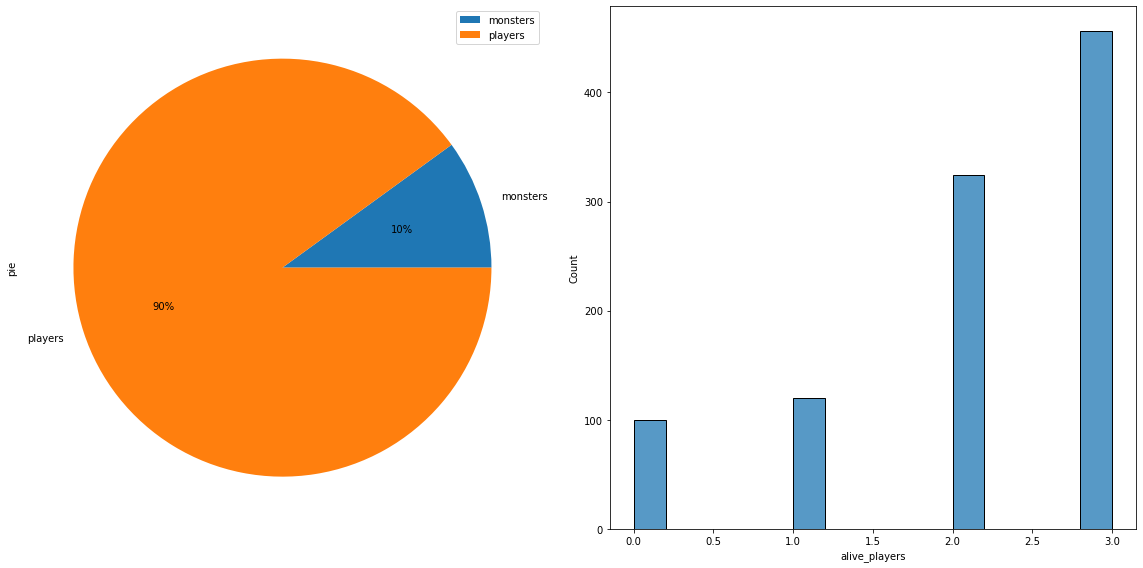

In [125]:
# Display all numeric values
fig, axes = plt.subplots(1, 2, figsize=(16, 8));
combat_df.groupby(['winners']).sum().plot(ax=axes[0], kind='pie', y='pie', autopct='%1.0f%%')

sns.histplot(ax=axes[1], data=combat_df["alive_players"]);
plt.tight_layout()
